In [1]:
%matplotlib inline
import Constants as C
from MakeModels import *
encoder = makeEncoder(C.batchSz)
decoder = makeDecoder()
autoencoder = makeAutoencoder(encoder,decoder)

autoencoder.load_weights('/home/ubuntu/SoftRobotRepresentation/ModelPrettyGoodBottleneck25.h5', by_name=True)

imageLSTM = makeImageLSTM(encoder)

Using TensorFlow backend.


(None, 25)
(1, None, 27)
(1, 512)
(1, 2)


In [ ]:
from IPython.display import SVG,display
from keras.utils.visualize_util import model_to_dot

display(SVG(model_to_dot(imageLSTM,show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
## Let's test some learning rates
import numpy as np
from numpy import random
import tqdm
from IPython.core.debugger import Pdb
from matplotlib import pyplot as plt

import pandas as pd


numEpochs = 50
numBatchesPerEpoch = 1000
nValBatches = 100

trainPath = "/home/ubuntu/SoftRobotRepresentation/Data/Training/0/"
valPath = "/home/ubuntu/SoftRobotRepresentation/Data/Validation/0/"

positionFiles = ['/home/ubuntu/SoftRobotRepresentation/Data/recordingRight.csv',
                 '/home/ubuntu/SoftRobotRepresentation/Data/recordingRight2.csv']

numFramesTrain = [21420,31430]
numFramesVal = [9180,13470]
numFrames = [e+f for e,f in zip(numFramesTrain,numFramesVal)]

posTables = [pd.read_csv(e) for e in positionFiles]

positionDataTrain = np.empty(shape=(0,2))
positionDataVal = np.empty(shape=(0,2))
for i in range(len(positionFiles)):
    positionData = posTables[i].as_matrix(columns=['x(m)','y(m)'])
    positionDataTrain = np.concatenate((positionDataTrain,positionData[:numFramesTrain[i],:]))
    positionDataVal = np.concatenate((positionDataVal,positionData[numFramesTrain[i]:numFrames[i],:]))
    
print str(positionDataTrain.shape) +" " + str(positionDataVal.shape)

def trainGenerator():
    files = os.listdir(trainPath)
    files = ['%s%06d.jpg'%(trainPath,i) for i in range(len(files))]
    res = np.zeros(shape=(C.timeSz,imDim,imDim,3))
    while True:
        for i in range(numBatchesPerEpoch):
            resPos = positionDataTrain[i*C.timeSz:(i+1)*(C.timeSz),:]
            for j in range(C.timeSz):
                index = i*C.timeSz+j
                res[j,:] = plt.imread(files[index]).astype('float32')/255.0
                
            posRes = positionDataTrain[i*C.timeSz+C.predictAhead:(i+1)*C.timeSz+C.predictAhead,:]
            yield ([resPos,res],posRes)
        
def valGenerator():  
    files = os.listdir(valPath)
    files = ['%s%06d.jpg'%(valPath,i) for i in range(len(files))]
    res = np.zeros(shape=(C.timeSz,imDim,imDim,3))
    while True:
        for i in range(nValBatches):
            resPos = positionDataVal[i*C.timeSz:(i+1)*(C.timeSz),:]
            for j in range(C.timeSz):
                index = i*C.timeSz+j
                res[j,:] = plt.imread(files[index]).astype('float32')/255.0
                
            posRes = positionDataVal[i*C.timeSz+C.predictAhead:(i+1)*C.timeSz+C.predictAhead,:]
            yield ([resPos,res],posRes)
            
            

def trainGeneratorPlainPos():
    res = np.zeros(shape=(C.timeSz,2))
    while True:
        for i in range(numBatchesPerEpoch):
            res = positionDataTrain[i*C.timeSz:i*(C.timeSz+1),:]
            posRes = positionDataTrain[i*(C.timeSz+1)+C.predictAhead,:]
            yield (res,posRes)
        
def valGenerator():  
    res = np.zeros(shape=(C.timeSz,2))
    while True:
        for i in range(nValBatches):
            res = positionDataVal[i*C.timeSz:i*(C.timeSz+1),:]
            posRes = positionDataVal[i*(C.timeSz+1)+C.predictAhead,:]
            yield (res,posRes)

In [ ]:
## Let's test some learning rates
from keras.optimizers import Adam
import numpy as np
from numpy import random
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau


lr = 5e-2
print "Learning rate=" + str(lr)
print "Compiling model"
imageLSTM.compile(optimizer=Adam(lr=lr),loss='mse')
print "Done compiling model"
history = imageLSTM.fit_generator(generator=trainGenerator(),
                                    samples_per_epoch=numBatchesPerEpoch*C.timeSz,
                                    nb_epoch=numEpochs,
                                    validation_data=valGenerator(),
                                    nb_val_samples=nValBatches*C.timeSz,
                                    callbacks=[TensorBoard(log_dir='/home/ubuntu/SoftRobotRepresentation/Data/Logs/0'),
                                               ModelCheckpoint('/home/ubuntu/SoftRobotRepresentation/LSTMModel.h5'),
                                               ReduceLROnPlateau(factor=0.2,patience=2)]
                                   )

In [2]:
import math
import numpy as np
from IPython.core.debugger import Pdb
from random import shuffle

C.batchSz = 64

def generator(path,shuf=False,numFrames=None):
    masterList = np.load(path)
    nFeatures = masterList.shape[1]-2
        
    X = np.zeros((C.batchSz,C.timeSz,nFeatures))
    y = np.zeros((C.batchSz,2))
    while True:
        for i in range(int(masterList.shape[0]/C.batchSz)-1):
            baseIndices = np.arange(i*C.batchSz,(i+1)*C.batchSz)
            if(shuf):
                baseIndices = np.random.randint(0,masterList.shape[0]-C.timeSz,size=(C.batchSz,))
            fail = False
            for j in range(C.batchSz):
                bi = baseIndices[j]
                if numFrames is not None and numFrames in np.arange(bi,bi+C.timeSz):
                    fail = True
                X[j,:,:] = masterList[bi:bi+C.timeSz,:-2]
                y[j,:] = masterList[bi+C.timeSz-1,-2:]    
            if not fail:
                yield (X,y)

In [ ]:
paths = ['/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy','/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy']
gengen = generator(paths[0],shuf=True)
gengen.next()

In [3]:
from MakeModels import *

nFeatures = autoencoder.layers[-2].output_shape[-1]+2
featureLSTM = makeFeatureLSTM(nFeatures)

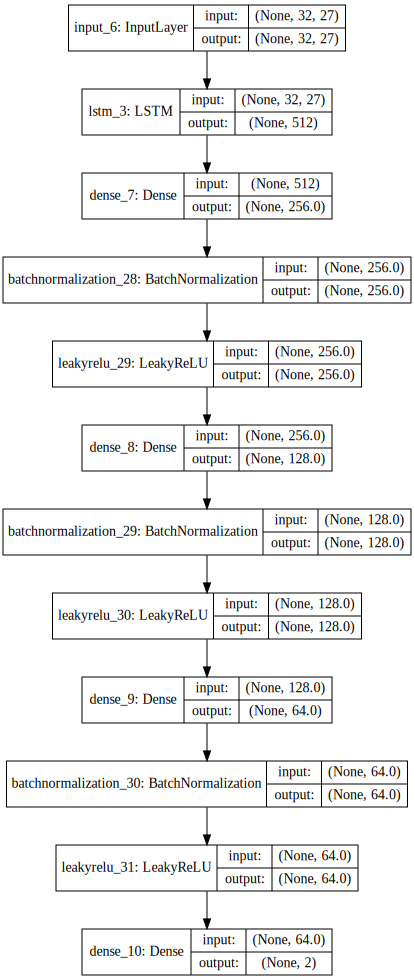

In [13]:
from IPython.display import SVG,display
from keras.utils.visualize_util import model_to_dot

display(SVG(model_to_dot(featureLSTM,show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
## Let's test some learning rates
from keras.optimizers import Adam
import numpy as np
from numpy import random
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
import shutil

trainPath = '/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy'
valPath = '/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy'

numEpochs = 2000
numBatchesPerEpoch = 500
nValBatches = 500

nFramesTrain = 21420
nFramesVal = 9180
# featureLSTM.load_weights('/home/ubuntu/SoftRobotRepresentation/featureLSTMModel1.h5')


lr = 5e-1
print "Learning rate=" + str(lr)
print "Compiling model"


if(os.path.isdir('/home/ubuntu/SoftRobotRepresentation/Data/Logs/')):
    shutil.rmtree('/home/ubuntu/SoftRobotRepresentation/Data/Logs/')

featureLSTM.compile(optimizer=Adam(lr=lr),loss='mse')
print "Done compiling model"
history = featureLSTM.fit_generator(generator=generator(trainPath,shuf=True,numFrames=nFramesTrain),
                                    samples_per_epoch=numBatchesPerEpoch*C.batchSz,
                                    nb_epoch=numEpochs,
                                    validation_data=generator(valPath,shuf=True,numFrames=nFramesVal),
                                    nb_val_samples=nValBatches*C.batchSz,
                                    callbacks=[TensorBoard(log_dir='/home/ubuntu/SoftRobotRepresentation/Data/Logs/1'),
                                               ModelCheckpoint('/home/ubuntu/SoftRobotRepresentation/featureOnlyLSTMModel.h5'),
                                               ReduceLROnPlateau(factor=0.5,patience=3)]
                                   )

In [ ]:
from matplotlib import pyplot as plt

import pandas as pd


paths = ['/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy','/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy']
gengen = generator(paths[0],shuf=False)

nPoints = 1024
res = np.zeros((nPoints,2))
res3 = np.zeros((nPoints,2))

for i in range(nPoints/C.batchSz):
    bluff = gengen.next()
    stuff = bluff[0]
    cruff = bluff[1]
    
    res[i*C.batchSz:(i+1)*C.batchSz,:] = stuff[:,0,-2:]
    res3[i*C.batchSz:(i+1)*C.batchSz,:] = cruff
    
gengen = generator(paths[0],shuf=False)
res2 = np.zeros((nPoints,2))    
for i in range(nPoints/C.timeSz):
    stuff = gengen.next()
    stuff = stuff[0]
    
    res2[i*C.timeSz:(i+1)*C.timeSz,:] = stuff[0,:,-2:]
    
    for j in range(C.timeSz/C.batchSz - 1):
        gengen.next()
    

xvals = np.arange(res.shape[0])    
plt.figure(1)
plt.plot(xvals,res[:,-1],xvals,res[:,-2],xvals, res3[:,-1], xvals, res3[:,-2])

plt.figure(2)
plt.plot(xvals,res2[:,-1],xvals,res2[:,-2])


posTable = pd.read_csv('/home/ubuntu/SoftRobotRepresentation/Data/recordingRight.csv')
positionData = posTable.as_matrix(columns=['x(m)','y(m)'])

plt.figure(3)
# plt.plot(xvals,positionData[xvals,-1],xvals,positionData[xvals,-2])

In [4]:
positionLSTM = makePlainLSTM()

In [5]:
import math
import numpy as np
from IPython.core.debugger import Pdb

C.batchSz = 64

def generatorPos(path,shuf=False,numFrames=None):
    masterList = np.load(path)
    nFeatures = masterList.shape[1]-2
        
    X = np.zeros((C.batchSz,C.timeSz,2))
    y = np.zeros((C.batchSz,2))
    while True:
        for i in range(int(masterList.shape[0]/C.batchSz)-1):
            baseIndices = np.arange(i*C.batchSz,(i+1)*C.batchSz)
            if(shuf):
                baseIndices = np.random.randint(0,masterList.shape[0]-C.timeSz,size=(C.batchSz,))
            fail = False
            for j in range(C.batchSz):
                bi = baseIndices[j]
                if numFrames is not None and numFrames in np.arange(bi,bi+C.timeSz):
                    fail = True
                X[j,:,:] = masterList[bi:bi+C.timeSz,-4:-2]
                y[j,:] = masterList[bi+C.timeSz-1,-2:]   
            if not fail:
                yield (X,y)

In [ ]:
## Let's test some learning rates
from keras.optimizers import Adam
import numpy as np
from numpy import random
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
import shutil

trainPath = '/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy'
valPath = '/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy'

numEpochs = 2000
numBatchesPerEpoch = 500
nValBatches = 500

nFramesTrain = 21420
nFramesVal = 9180

if(os.path.isdir('/home/ubuntu/SoftRobotRepresentation/Data/Logs/')):
    shutil.rmtree('/home/ubuntu/SoftRobotRepresentation/Data/Logs/')
    
positionLSTM.load_weights('/home/ubuntu/SoftRobotRepresentation/positionLSTMModel.h5')

lr = 1e-1
print "Learning rate=" + str(lr)
print "Compiling model"
positionLSTM.compile(optimizer=Adam(lr=lr),loss='mse')
print "Done compiling model"
history = positionLSTM.fit_generator(generator=generatorPos(trainPath,shuf=True,numFrames=nFramesTrain),
                                    samples_per_epoch=numBatchesPerEpoch*C.batchSz,
                                    nb_epoch=numEpochs,
                                    validation_data=generatorPos(valPath,shuf=True,numFrames=nFramesVal),
                                    nb_val_samples=nValBatches*C.batchSz,
                                    callbacks=[TensorBoard(log_dir='/home/ubuntu/SoftRobotRepresentation/Data/Logs/1'),
                                               ModelCheckpoint('/home/ubuntu/SoftRobotRepresentation/positionLSTMModel.h5'),
                                               ReduceLROnPlateau(factor=0.5,patience=3)]
                                   )

In [ ]:
from IPython.display import SVG,display
from keras.utils.visualize_util import model_to_dot

display(SVG(model_to_dot(positionLSTM,show_shapes=True).create(prog='dot', format='svg')))

In [6]:
import math
import numpy as np
from IPython.core.debugger import Pdb

C.batchSz = 64

def generatorFeature(path,shuf=False,numFrames=None):
    masterList = np.load(path)
    nFeatures = masterList.shape[1]-2
        
    X = np.zeros((C.batchSz,C.timeSz,nFeatures-2))
    y = np.zeros((C.batchSz,2))
    while True:
        for i in range(int(masterList.shape[0]/C.batchSz)-1):
            baseIndices = np.arange(i*C.batchSz,(i+1)*C.batchSz)
            if(shuf):
                baseIndices = np.random.randint(0,masterList.shape[0]-C.timeSz,size=(C.batchSz,))
            fail = False
            for j in range(C.batchSz):
                bi = baseIndices[j]
                if numFrames is not None and numFrames in np.arange(bi,bi+C.timeSz):
                    fail = True
                X[j,:,:] = masterList[bi:bi+C.timeSz,:-4]
                y[j,:] = masterList[bi+C.timeSz-1,-2:]   
            if not fail:
                yield (X,y)

In [7]:
from MakeModels import *

nFeatures = autoencoder.layers[-2].output_shape[-1]
featureOnlyLSTM = makeFeatureLSTM(nFeatures)

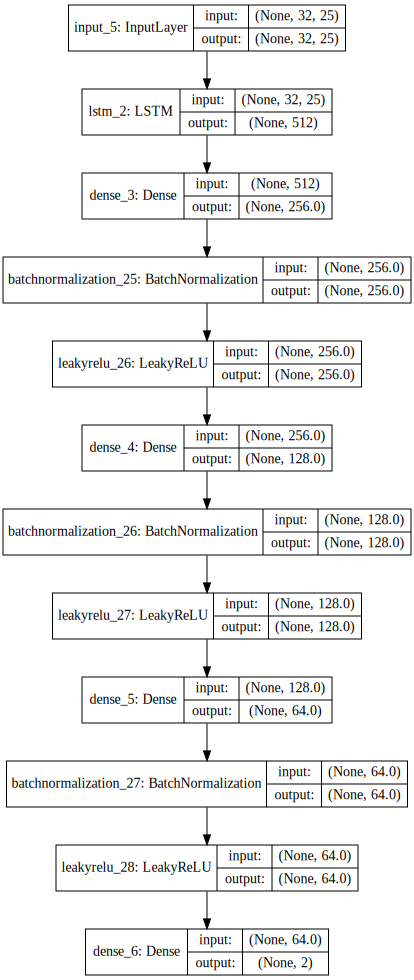

In [6]:
from IPython.display import SVG,display
from keras.utils.visualize_util import model_to_dot

display(SVG(model_to_dot(featureOnlyLSTM,show_shapes=True).create(prog='dot', format='svg')))

In [10]:
## Let's test some learning rates
from keras.optimizers import Adam
import numpy as np
from numpy import random
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
import shutil

trainPath = '/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy'
valPath = '/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy'

numEpochs = 2000
numBatchesPerEpoch = 500
nValBatches = 500

nFramesTrain = 21420
nFramesVal = 9180
# featureOnlyLSTM.load_weights('/home/ubuntu/SoftRobotRepresentation/featureOnlyLSTMModel1.h5')


lr = 2.5e-1
print "Learning rate=" + str(lr)
print "Compiling model"


if(os.path.isdir('/home/ubuntu/SoftRobotRepresentation/Data/Logs/')):
    shutil.rmtree('/home/ubuntu/SoftRobotRepresentation/Data/Logs/')

featureOnlyLSTM.compile(optimizer=Adam(lr=lr),loss='mse')
print "Done compiling model"
history = featureOnlyLSTM.fit_generator(generator=generatorFeature(trainPath,shuf=True,numFrames=nFramesTrain),
                                    samples_per_epoch=numBatchesPerEpoch*C.batchSz,
                                    nb_epoch=numEpochs,
                                    validation_data=generatorFeature(valPath,shuf=True,numFrames=nFramesVal),
                                    nb_val_samples=nValBatches*C.batchSz,
                                    callbacks=[TensorBoard(log_dir='/home/ubuntu/SoftRobotRepresentation/Data/Logs/1'),
                                               ModelCheckpoint('/home/ubuntu/SoftRobotRepresentation/featureOnlyLSTMModel.h5'),
                                               ReduceLROnPlateau(factor=0.5,patience=4)]
                                   )

Learning rate=0.25
Compiling model
Done compiling model
Epoch 1/2000
32000/32000 [==============================] - 53s - loss: 0.2893 - val_loss: 0.3085
Epoch 2/2000
32000/32000 [==============================] - 52s - loss: 0.1762 - val_loss: 0.2368
Epoch 3/2000
32000/32000 [==============================] - 52s - loss: 0.1804 - val_loss: 0.3900
Epoch 4/2000
32000/32000 [==============================] - 52s - loss: 0.1628 - val_loss: 0.1995
Epoch 5/2000
32000/32000 [==============================] - 53s - loss: 0.1342 - val_loss: 0.1697
Epoch 6/2000
32000/32000 [==============================] - 52s - loss: 0.1106 - val_loss: 0.1876
Epoch 7/2000
32000/32000 [==============================] - 52s - loss: 0.1938 - val_loss: 0.1708
Epoch 8/2000
32000/32000 [==============================] - 52s - loss: 0.1167 - val_loss: 0.1880
Epoch 9/2000
32000/32000 [==============================] - 52s - loss: 0.1190 - val_loss: 0.2521
Epoch 10/2000
32000/32000 [==============================] - 5

KeyboardInterrupt: 

In [13]:
## Feature Decoder

import math
import numpy as np
from IPython.core.debugger import Pdb

C.batchSz = 64

def generatorDecodeFeature(path,shuf=False):
    masterList = np.load(path)
    nFeatures = masterList.shape[1]-2
        
    X = np.zeros((C.batchSz,nFeatures-2))
    y = np.zeros((C.batchSz,2))
    while True:
        for i in range(int(masterList.shape[0]/C.batchSz)):
            baseIndices = np.arange(i*C.batchSz,(i+1)*C.batchSz)
            if(shuf):
                baseIndices = np.random.randint(0,masterList.shape[0],size=(C.batchSz,))
            X = masterList[baseIndices,:-4]
            y = masterList[baseIndices,-4:-2] 
            yield (X,y)

In [3]:
from MakeModels import *

nFeatures = autoencoder.layers[-2].output_shape[-1]
featureDecoder = makeFeatureDecoder(nFeatures)

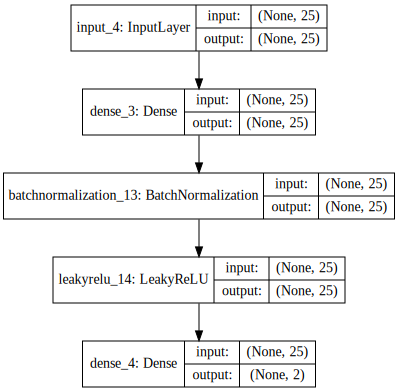

In [4]:
from IPython.display import SVG,display
from keras.utils.visualize_util import model_to_dot

display(SVG(model_to_dot(featureDecoder,show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
## Let's test some learning rates
from keras.optimizers import Adam
import numpy as np
from numpy import random
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
import shutil

trainPath = '/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy'
valPath = '/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy'

numEpochs = 2000
numBatchesPerEpoch = 500
nValBatches = 500

nFramesTrain = 21420
nFramesVal = 9180


lr = 1e-1
print "Learning rate=" + str(lr)
print "Compiling model"


if(os.path.isdir('/home/ubuntu/SoftRobotRepresentation/Data/Logs/')):
    shutil.rmtree('/home/ubuntu/SoftRobotRepresentation/Data/Logs/')

featureDecoder.compile(optimizer=Adam(lr=lr),loss='mse')
print "Done compiling model"
history = featureDecoder.fit_generator(generator=generatorDecodeFeature(trainPath,shuf=True),
                                    samples_per_epoch=numBatchesPerEpoch*C.batchSz,
                                    nb_epoch=numEpochs,
                                    validation_data=generatorDecodeFeature(valPath,shuf=True),
                                    nb_val_samples=nValBatches*C.batchSz,
                                    callbacks=[TensorBoard(log_dir='/home/ubuntu/SoftRobotRepresentation/Data/Logs/1'),
                                               ModelCheckpoint('/home/ubuntu/SoftRobotRepresentation/featureDecoder.h5'),
                                               ReduceLROnPlateau(factor=0.5,patience=4)]
                                   )

Learning rate=0.1
Compiling model
Done compiling model
Epoch 1/2000
32000/32000 [==============================] - 5s - loss: 0.5011 - val_loss: 0.2544
Epoch 2/2000
32000/32000 [==============================] - 5s - loss: 0.3193 - val_loss: 0.4821
Epoch 3/2000
32000/32000 [==============================] - 5s - loss: 0.3479 - val_loss: 0.2640
Epoch 4/2000
32000/32000 [==============================] - 5s - loss: 0.3345 - val_loss: 0.2268
Epoch 5/2000
21824/32000 [===================>..........] - ETA: 0s - loss: 0.3114

In [8]:
import math
import numpy as np
from IPython.core.debugger import Pdb

C.batchSz = 64

def gep(path,shuf=False,numFrames=None):
    masterList = np.load(path)
    nFeatures = masterList.shape[1]-2
        
    X = np.zeros((C.batchSz,C.timeSz,nFeatures))
    y = np.zeros((C.batchSz,2))
    kk = 0
    while True:
        for i in range(int(masterList.shape[0]/C.batchSz)-1):
            baseIndices = np.arange(i*C.batchSz,(i+1)*C.batchSz)
            if(shuf):
                baseIndices = np.random.randint(0,masterList.shape[0]-C.timeSz,size=(C.batchSz,))
            baseIndices[0] = kk
            kk = kk+1
            fail = False
            for j in range(C.batchSz):
                bi = baseIndices[j]
                if numFrames is not None and numFrames in np.arange(bi,bi+C.timeSz):
                    fail = True
                X[j,:,:] = masterList[bi:bi+C.timeSz,:-2]
                y[j,:] = masterList[bi+C.timeSz-1,-2:]    
            if not fail:
                yield (X,y)

In [9]:
from keras.optimizers import Adam

positionLSTM.load_weights('/home/ubuntu/SoftRobotRepresentation/positionLSTMModel.h5')
featureLSTM.load_weights('/home/ubuntu/SoftRobotRepresentation/featureLSTMModel1.h5')
featureOnlyLSTM.load_weights('/home/ubuntu/SoftRobotRepresentation/featureOnlyLSTMModel1.h5')

from matplotlib import pyplot as plt

import pandas as pd
from tqdm import tqdm

nFramesTrain = 21420
nFramesVal = 9180

paths = ['/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy','/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy']
gengen = gep(paths[1],shuf=True,numFrames=nFramesVal)

print C.batchSz
featureLSTM.compile(optimizer=Adam(lr=1e-1),loss='mse')
featureOnlyLSTM.compile(optimizer=Adam(lr=1e-1),loss='mse')

blah = featureLSTM.evaluate_generator(gengen, C.batchSz*32)

nPoints = 2048
X = np.zeros((nPoints,2))
y = np.zeros((nPoints,2))
ypred = np.zeros((nPoints,2))
ypredf = np.zeros((nPoints,2))
ypredfo = np.zeros((nPoints,2))

for i in tqdm(range(nPoints)):
    bluff = gengen.next()
    stuff = bluff[0]
    cruff = bluff[1]
    
    oup = positionLSTM.predict_on_batch(stuff[:,:,-2:])
    oupf = featureLSTM.predict_on_batch(stuff)
    oupfo = featureOnlyLSTM.predict_on_batch(stuff[:,:,:-2])
    
    X[i,:] = stuff[0,0,-2:]
    y[i,:] = cruff[0,:]
    ypred[i:,:] = oup[0,:]
    ypredf[i,:] = oupf[0,:]
    ypredfo[i,:] = oupfo[0,:]

64


100%|██████████| 2048/2048 [01:38<00:00, 20.83it/s]


In [18]:
blah

0.10432498971931636

(2048, 2)


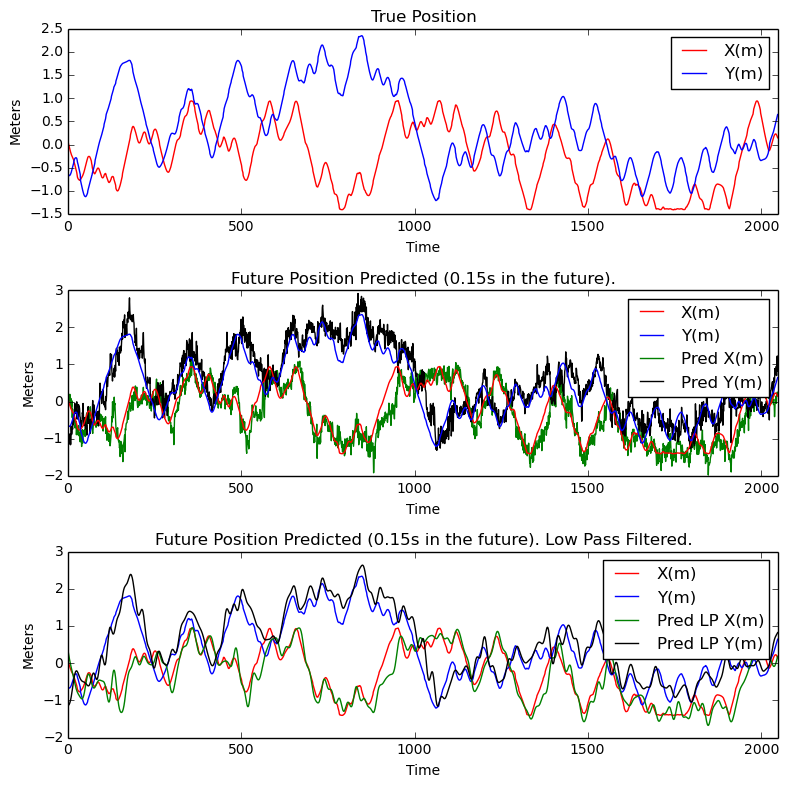

In [28]:
from scipy import signal 

print ypred.shape
[b,a] = signal.butter(10,0.1)
ypredlow = np.zeros_like(ypred)
ypredlowf = np.zeros_like(ypred)
ypredlowfo = np.zeros_like(ypred)

ypredlowf[:,-1] = signal.filtfilt(b,a,ypredf[:,-1])
ypredlowf[:,-2] = signal.filtfilt(b,a,ypredf[:,-2])
ypredlow[:,-1] = signal.filtfilt(b,a,ypred[:,-1])
ypredlow[:,-2] = signal.filtfilt(b,a,ypred[:,-2])
ypredlowfo[:,-1] = signal.filtfilt(b,a,ypredfo[:,-1])
ypredlowfo[:,-2] = signal.filtfilt(b,a,ypredfo[:,-2])

fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(8,8))

xvals = np.arange(X.shape[0])    
plt.subplot(3,1,1)
line1, = plt.plot(xvals,y[:,-1],'r')
plt.hold(b=True)
line2, = plt.plot(xvals,y[:,-2],'b')
plt.legend([line1, line2],['X(m)','Y(m)'])
plt.title('True Position')
plt.xlabel('Time')
plt.ylabel('Meters')
plt.xlim([min(xvals), max(xvals)])
plt.subplot(3,1,2)
line3, = plt.plot(xvals,ypredfo[:,-1],'g')
line4, = plt.plot(xvals,ypredfo[:,-2],'k')
line1, = plt.plot(xvals,y[:,-1],'r')
line2, = plt.plot(xvals,y[:,-2],'b')
plt.legend([line1, line2, line3, line4],['X(m)','Y(m)','Pred X(m)', 'Pred Y(m)'])
plt.title('Future Position Predicted (0.15s in the future).')
plt.xlabel('Time')
plt.ylabel('Meters')
plt.xlim([min(xvals), max(xvals)])
plt.subplot(3,1,3)
line1, = plt.plot(xvals,y[:,-1],'r')
line2, = plt.plot(xvals,y[:,-2],'b')
line3, = plt.plot(xvals,ypredlowfo[:,-1],'g')
line4, = plt.plot(xvals,ypredlowfo[:,-2],'k')
plt.legend([line1, line2, line3, line4],['X(m)','Y(m)','Pred LP X(m)', 'Pred LP Y(m)'])
plt.title('Future Position Predicted (0.15s in the future). Low Pass Filtered.')
plt.xlabel('Time')
plt.ylabel('Meters')
plt.xlim([min(xvals), max(xvals)])
fig.tight_layout()

fig.savefig('/home/ubuntu/SoftRobotRepresentation/Plots/Predicted.pdf', format='pdf')

# plt.figure(2)
# plt.plot(xvals,y[:,-1], xvals, y[:,-2],xvals,ypredf[:,-1],xvals,ypredf[:,-2])
# plt.figure(3)
# plt.plot(xvals,y[:,-1], xvals, y[:,-2],xvals,ypredlowf[:,-1])
# plt.figure(4)
# plt.plot(xvals,y[:,-1], xvals, y[:,-2],xvals,ypred[:,-1],xvals,ypred[:,-2])
# plt.figure(5)
# plt.plot(xvals,y[:,-1], xvals, y[:,-2],xvals,ypredlow[:,-1])
# plt.figure(6)
# plt.plot(xvals,y[:,-1], xvals, y[:,-2],xvals,ypredfo[:,-1],xvals,ypredfo[:,-2])
# plt.figure(7)